<!-- HTML file automatically generated from DocOnce source (https://github.com/doconce/doconce/)
doconce format html exercisesweek41.do.txt  -->
<!-- dom:TITLE: Exercises week 41 -->

In [20]:
import autograd.numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from autograd import grad


def Design(x,degree):
    X = np.zeros((len(x[:,0]),degree+1))
    for i in range(degree+1):
        X[:,i] = x[:,0]**i
    return X

def MSE(z,zpred): #z=target data, zpred=predicted target data
    return np.mean((z-zpred)**2)


def R2(z,zpred):
    return 1 - np.sum((z - zpred)**2) / np.sum((z - np.mean(z)) ** 2)

#AUTOGRAD 
#Similar to week 39: Using Autograd with OLS
def autograd_gradient(X, y, beta, lmbda=0):
    cost = lambda beta:  (1.0 / n) * np.sum((y - X @ beta)**2) + lmbda * np.sum(beta**2)
    return grad(cost)(beta)


#### Task 1 Plain GD

In [21]:
# Gradient Descent
def GD(X, y, beta, eta, momentum = False,  delta_momentum = 0.0, change = 0.0, lmbda = 0, Niterations = 100):
    n = X.shape[0]
    beta = np.copy(beta)
    for iter in range(Niterations):
        betaold = np.copy(beta)
        # Taken from week 39: Program example for gradient descent with Ridge Regression
        # if lmbda is 0, the function will perform ordinary least squares regression. Default
        gradient = autograd_gradient(X, y, beta, lmbda)
        #Momemtum code taken from Week 39: Same code but now with momentum gradient descent
        if momentum:
            new_change = eta * gradient + delta_momentum * change
            beta -= new_change
            change = new_change
            
        else:
            beta -= eta * gradient

        if np.linalg.norm(beta-betaold) < 1e-5:
            print(f"{eta} {lmbda}Stopped after {iter+1} iterations")
            return beta
        
   # print(f"Stopped after {Niterations} iterations")
    return beta


In [22]:
"""
Creates two heatmaps, one for MSE and one for R2, using plain gradient descent for different learning rates and hyperparameters.
"""
def plotHeatmapGD(X, y, beta, lr, lmbda, Niterations=2000):
    mse = np.zeros((len(lr),len(lmbda)))
    r2 = np.zeros((len(lr),len(lmbda)))
    min = 100
    for i in range(len(lr)):
        for j in range(len(lmbda)):
            beta_gd = GD(X = X,y= y,beta = beta,Niterations=Niterations,eta=lr[i],lmbda=lmbda[j])
            print(f"lr={lr[i]}, lmbda={lmbda[j]}")
            print(beta_gd)
            y_gd = X@beta_gd
            mse[i][j] = MSE(y,y_gd)
            r2[i][j] = R2(y,y_gd)
            print("MSE=",mse[i][j])
            print()
            if mse[i][j]<min:
                min = mse[i][j] = MSE(y,y_gd)
                minlr = lr[i]
                minlmbda = lmbda[j]
    
    print(f"Smallest MSE={min} with learning rate {minlr} and hyperparameter {minlmbda}")
    
    xticks = [f"$0$"]+[f"$10^{{{int(np.log10(val))}}}$" for val in np.logspace(-9,0,10)]
    yticks = [f"$10^{{{int(np.log10(val))}}}$" for val in lr]
    
    fig1, ax = plt.subplots(layout='constrained', figsize=(13,11))
    heatmap_mse = sns.heatmap(mse, annot=True, cmap="YlGnBu",yticklabels=yticks,xticklabels=xticks, vmin = 0 ,annot_kws={"fontsize":22} ,ax=ax)
    
    cbar_mse = heatmap_mse.collections[0].colorbar
    cbar_mse.ax.tick_params(labelsize=19)  # Adjust font size of colorbar ticks
    cbar_mse.set_label('MSE', fontsize=19)
    
    ax.tick_params(left=False, bottom=False)
    ax.set_title("Accuracy, GD")
    ax.set_ylabel("$\eta$",fontsize=19)
    ax.set_xlabel("$\lambda$",fontsize=19)
    ax.tick_params(axis='both', which='major', labelsize=19)
    
    
    fig2, ax = plt.subplots(layout='constrained', figsize=(13,11))
    heatmap_r2 = sns.heatmap(r2, annot=True, cmap="YlGnBu",yticklabels=yticks, xticklabels=xticks, vmax = 1 ,annot_kws={"fontsize":22}, ax=ax)
    
    cbar_r2 = heatmap_r2.collections[0].colorbar
    cbar_r2.ax.tick_params(labelsize=19)  # Adjust font size of colorbar ticks
    cbar_r2.set_label("$R^2$", fontsize=19)
    
    ax.tick_params(left=False, bottom=False)
    ax.set_title("Accuracy, GD")
    ax.set_ylabel("$\eta$",fontsize=19)
    ax.set_xlabel("$\lambda$",fontsize=19)
    ax.tick_params(axis='both', which='major', labelsize=19)
    plt.show()


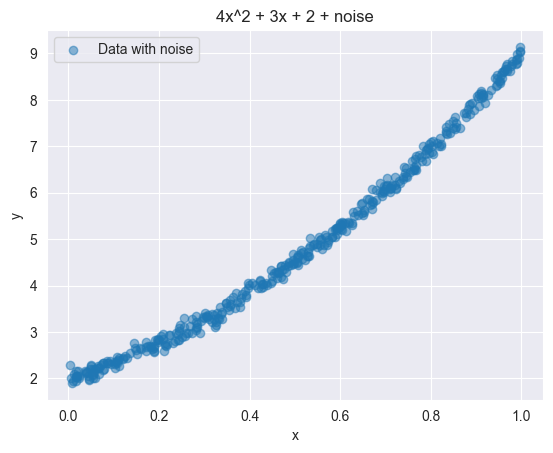

1e-10 0.0Stopped after 1 iterations
lr=1e-10, lmbda=0.0
[[-0.95218689]
 [ 1.06102228]
 [ 1.74880659]]
MSE= 23.421536241257947

1e-10 1e-09Stopped after 1 iterations
lr=1e-10, lmbda=1e-09
[[-0.95218689]
 [ 1.06102228]
 [ 1.74880659]]
MSE= 23.421536241257947

1e-10 1e-08Stopped after 1 iterations
lr=1e-10, lmbda=1e-08
[[-0.95218689]
 [ 1.06102228]
 [ 1.74880659]]
MSE= 23.421536241257947

1e-10 1e-07Stopped after 1 iterations
lr=1e-10, lmbda=1e-07
[[-0.95218689]
 [ 1.06102228]
 [ 1.74880659]]
MSE= 23.421536241257947

1e-10 1e-06Stopped after 1 iterations
lr=1e-10, lmbda=1e-06
[[-0.95218689]
 [ 1.06102228]
 [ 1.74880659]]
MSE= 23.421536241257947

1e-10 1e-05Stopped after 1 iterations
lr=1e-10, lmbda=1e-05
[[-0.95218689]
 [ 1.06102228]
 [ 1.74880659]]
MSE= 23.42153624125795

1e-10 0.0001Stopped after 1 iterations
lr=1e-10, lmbda=0.0001
[[-0.95218689]
 [ 1.06102228]
 [ 1.74880659]]
MSE= 23.421536241258018

1e-10 0.001Stopped after 1 iterations
lr=1e-10, lmbda=0.001
[[-0.95218689]
 [ 1.061022

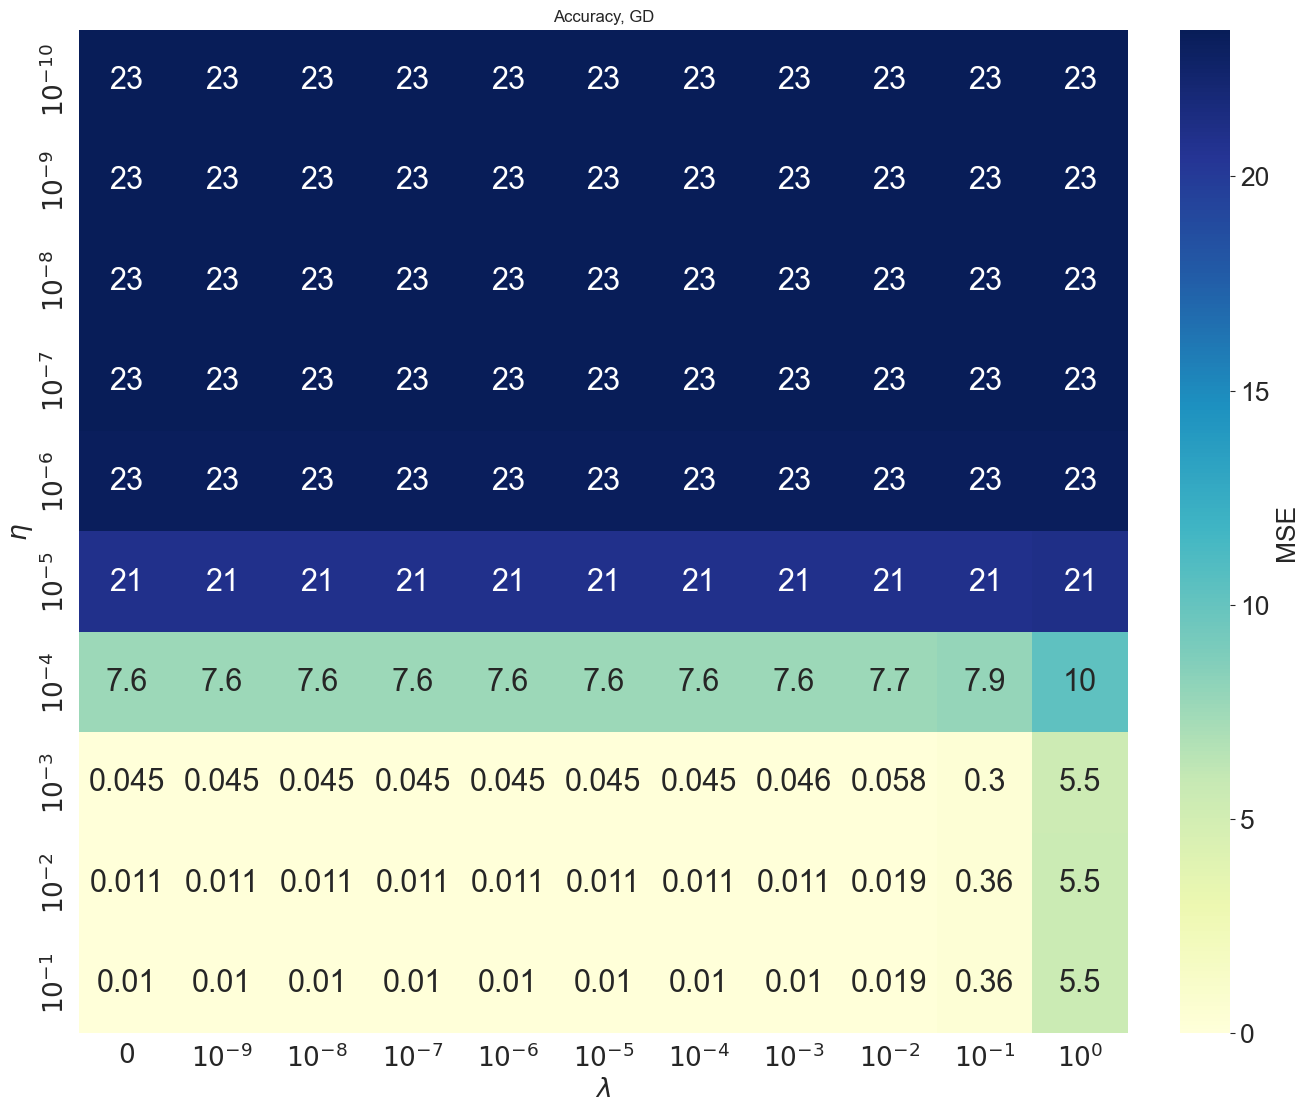

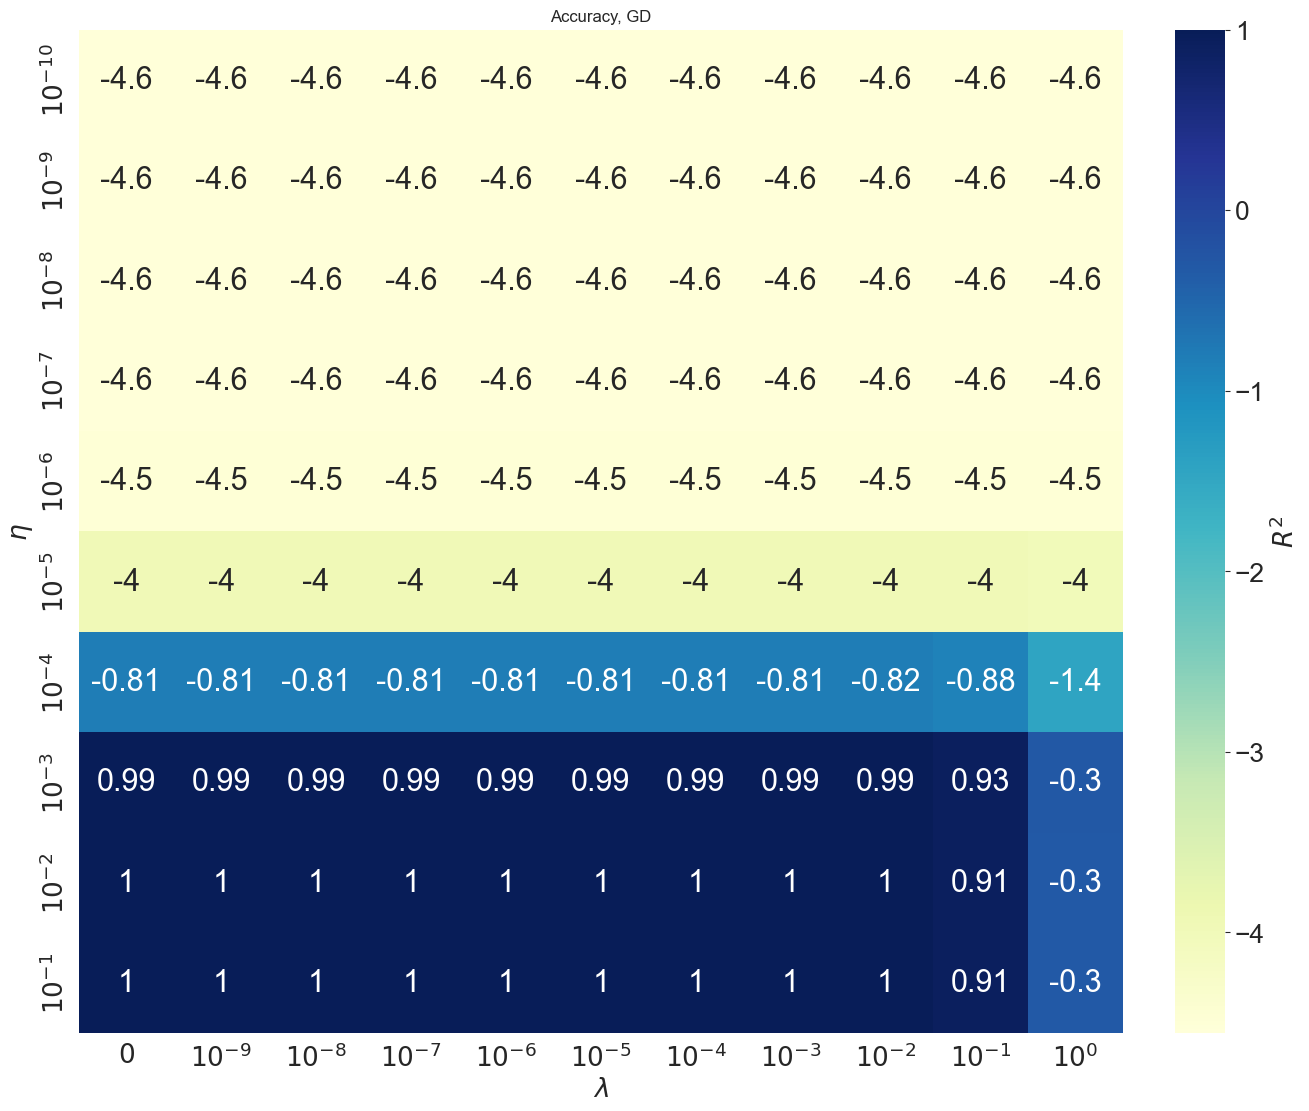

In [23]:
# Data generation
np.random.seed(2014)
n = 400
x = np.random.rand(n,1)
y = 2 + 3*x + 4*x**2 + 0.1*np.random.randn(n,1) #4x^2 + 3x + 2 + noise
p = 2 

X = Design(x,p) 
beta = np.random.randn(p+1,1) 

lr = np.logspace(-10, -1, 10)  # Learning rates for eta
lmbda = np.insert(np.logspace(-9, 0, 10), 0, 0)  # Regularization parameters for lambda, including 0 for OLS


# Plot the data points
plt.scatter(x, y, label="Data with noise", alpha=0.5)
plt.xlabel("x")
plt.ylabel("y")
plt.title("4x^2 + 3x + 2 + noise")
plt.legend()
plt.show()

plotHeatmapGD(X, y, beta, lr, lmbda, Niterations = 2000)




### Step 2: Gradient Descent with Momentum
Add momentum to the plain GD code and compare convergence with a fixed learning rate (you may need to tune the learning rate). Keep using the analytical expression for the gradient.

In [24]:
#Plot showing the convergence of the OLS and Ridge regression with and without momentum
def plot_OLS_Ridge_convergence(X, y, beta, eta, lambdas, Niterations=100, momentum=0.3, change=0.00):
    plain_ridge = {lmbda: [] for lmbda in lambdas}
    momentum_ridge = {lmbda: [] for lmbda in lambdas}

    for lmbda in lambdas:
        plain_mse_values = []
        momentum_mse_values = []

        for n in range(1, Niterations + 1):
            # With and without momentum
            beta_plain_ridge = GD(X, y, np.copy(beta), eta=eta, momentum=False, lmbda=lmbda, Niterations=n)
            beta_momentum_ridge = GD(X, y, np.copy(beta), eta=eta, momentum=True, delta_momentum=momentum, change=change, lmbda=lmbda, Niterations=n)

            # Calculate predictions and MSE for current lambda and iteration
            plain_mse_values.append(MSE(y, X @ beta_plain_ridge))
            momentum_mse_values.append(MSE(y, X @ beta_momentum_ridge))
            
        plain_ridge[lmbda] = plain_mse_values
        momentum_ridge[lmbda] = momentum_mse_values

    # Plotting convergence for each lambda
    plt.figure(figsize=(12, 8)) 

    for lmbda in lambdas:
        plt.plot(range(1, Niterations + 1), plain_ridge[lmbda], label=f'Plain GD, λ={lmbda}')
        plt.plot(range(1, Niterations + 1), momentum_ridge[lmbda], linestyle='--', label=f'Momentum GD, λ={lmbda}')

    plt.xlabel('Number of Iterations')
    plt.ylabel('Mean Squared Error')
    plt.title(f'OLS and Ridge Convergence with and without Momentum (η={eta}, momentum={momentum})')
    plt.legend()
    plt.yscale("log") 
    plt.show()



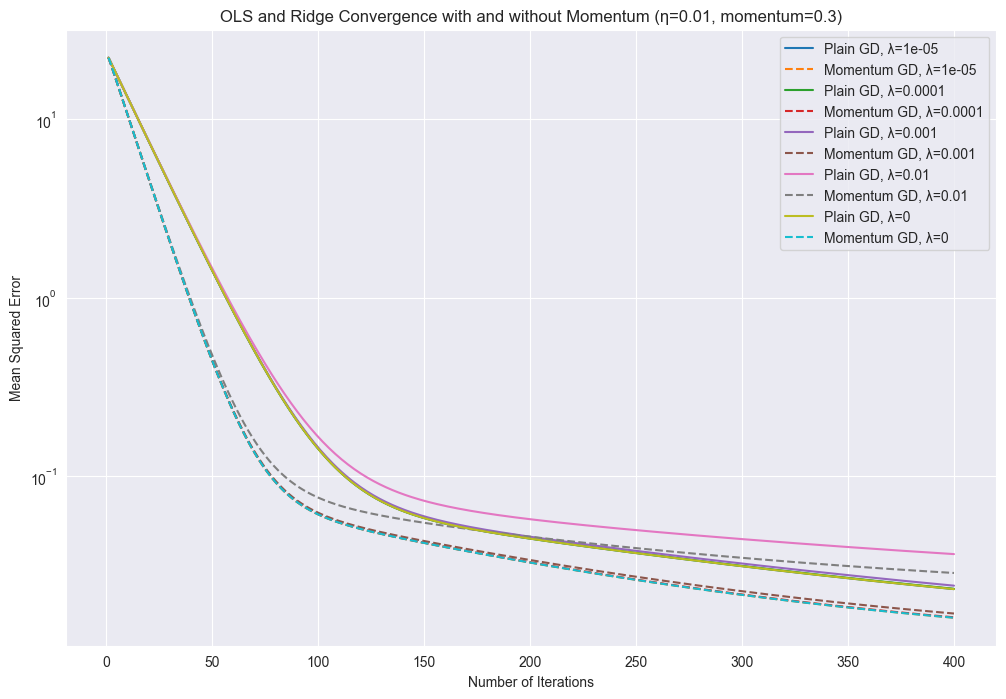

In [25]:
# Data generation
np.random.seed(2014)
n = 400
x = np.random.rand(n,1)
y = 2 + 3*x + 4*x**2 + 0.1*np.random.randn(n,1) #4x^2 + 3x + 2 + noise
p = 2

X = Design(x,p)
beta = np.random.randn(p+1,1)

# Parameters
learning_rates = np.logspace(-5, -1, 5)
lambdas = [1e-5, 1e-4, 1e-3, 1e-2, 0]
eta = 0.01
Niterations = 400
momentum = 0.3
change = 0.00

plot_OLS_Ridge_convergence(X, y, beta, eta, lambdas, Niterations=Niterations, momentum = momentum, change = change)


### Step 3: Stochastic Gradient Descent (SGD) with Mini-batches

In [26]:
#Code taken and modified from week 39: Code with a Number of Minibatches which varies, analytical gradient
def learning_schedule(t, t0=5, t1=50):
    return t0/(t+t1)

#Code taken and modified from week 39: Code with a Number of Minibatches which varies, analytical gradient
def SGD(X, y, beta, n = 100, n_epochs=50, batch_size=5, momentum=0.3, change=0.0, ridge=False, lmbda=0, t0 =5, t1 = 50):
    M = batch_size
    m = int(n / M)  # Number of mini-batches
    for epoch in range(n_epochs):
        for i in range(m):
            random_index = M * np.random.randint(m)
            xi = X[random_index:random_index + M]
            yi = y[random_index:random_index + M]

            if ridge:
                gradient = autograd_gradient(xi,yi , beta, lmbda)
            
            else:
                gradient = autograd_gradient(xi, yi, beta, lmbda)

            eta = learning_schedule(epoch * m + i, t0, t1)
            new_change = eta * gradient + momentum * change
            beta -= new_change
            change = new_change

    return beta


In [27]:
# Plot comparing the the convergence of the OLS between GD and SGD
def plot_OLS_convergence_GD_vs_SGD(X, y, beta, eta, Niterations=200, batch_size=5, momentum=0.3, change=0.0):
    mse_GD, mse_SGD = [], []
    beta_GD = beta.copy()
    beta_SGD = beta.copy()

    # Perform GD and SGD
    for n in range(1, Niterations + 1):
        beta_GD = GD(X, y, beta_GD.copy(), eta=eta, momentum=True, delta_momentum=momentum, change=change, Niterations=n)
        mse_GD.append(MSE(y, X @ beta_GD))
        
        beta_SGD = SGD(X, y, beta_SGD.copy(), n=len(y), n_epochs=n, batch_size=batch_size, momentum=momentum, change=change, ridge=False)
        mse_SGD.append(MSE(y, X @ beta_SGD))

    plt.figure(figsize=(10, 6))
    plt.plot(range(1, Niterations + 1), mse_GD, 'r', label=f'GD with Momentum (eta={eta}, momentum={momentum})')
    plt.plot(range(1, Niterations + 1), mse_SGD, 'b', label=f'SGD with Momentum (batch size={batch_size}, momentum={momentum})')
    plt.xlabel('Number of Iterations')
    plt.ylabel('Mean Squared Error')
    plt.title('OLS Convergence: GD vs SGD (both with Momentum)')
    plt.legend()
    plt.yscale("log") 
    plt.show()



0.01 0Stopped after 1 iterations
0.01 0Stopped after 1 iterations
0.01 0Stopped after 1 iterations
0.01 0Stopped after 1 iterations
0.01 0Stopped after 1 iterations
0.01 0Stopped after 1 iterations
0.01 0Stopped after 1 iterations
0.01 0Stopped after 1 iterations
0.01 0Stopped after 1 iterations
0.01 0Stopped after 1 iterations
0.01 0Stopped after 1 iterations
0.01 0Stopped after 1 iterations
0.01 0Stopped after 1 iterations
0.01 0Stopped after 1 iterations
0.01 0Stopped after 1 iterations
0.01 0Stopped after 1 iterations
0.01 0Stopped after 1 iterations
0.01 0Stopped after 1 iterations
0.01 0Stopped after 1 iterations
0.01 0Stopped after 1 iterations
0.01 0Stopped after 1 iterations
0.01 0Stopped after 1 iterations
0.01 0Stopped after 1 iterations
0.01 0Stopped after 1 iterations
0.01 0Stopped after 1 iterations
0.01 0Stopped after 1 iterations
0.01 0Stopped after 1 iterations
0.01 0Stopped after 1 iterations
0.01 0Stopped after 1 iterations
0.01 0Stopped after 1 iterations
0.01 0Stop

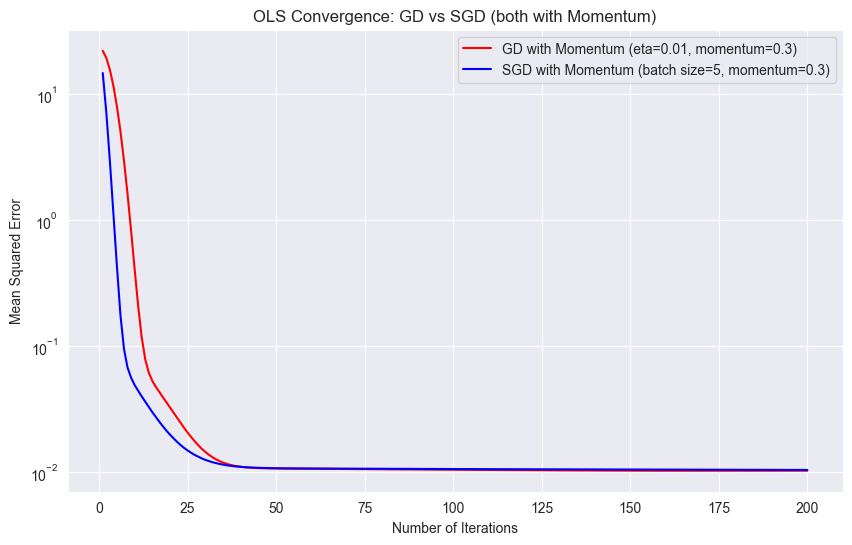

In [28]:
# Data generation
np.random.seed(2014)
n = 400
x = np.random.rand(n,1)
y = 2 + 3*x + 4*x**2 + 0.1*np.random.randn(n,1) #4x^2 + 3x + 2 + noise
p = 2
X = Design(x,p)
beta = np.random.randn(p+1,1)

eta = 0.01 
Niterations = 200
batch_size = 5
momentum = 0.3

plot_OLS_convergence_GD_vs_SGD(X, y, beta, eta, Niterations, batch_size, momentum, change=0.0)



In [29]:
#Plot showing the effect of mini-batch size and number of epochs the regularization parameter
def plot_Ridge_OLS_MSE_changes_minibatch(X, y, beta, lambdas=[1e-5, 1e-4, 1e-3, 1e-2, 1e-1], mini_batch_sizes=[5, 10, 20, 50], epochs=[1, 5, 10, 20, 30, 50], t0=5, t1=50, momentum=0.3, change=0.0):
    n = len(y)

    #For each lambda run SGD with Ridge regression for each epoch and mini-batch size
    for lmbda in lambdas:
        mse_values = np.zeros((len(epochs), len(mini_batch_sizes)))
        for i, n_epochs in enumerate(epochs):
            for j, batch_size in enumerate(mini_batch_sizes):
                beta_SGD = SGD(X, y, beta.copy(), n=n, n_epochs=n_epochs, batch_size=batch_size, momentum=momentum, change=change, ridge=True, lmbda=lmbda, t0=t0, t1=t1)
                y_pred_SGD = X @ beta_SGD
                mse_values[i, j] = MSE(y, y_pred_SGD)  

       #Heatmap creation
        plt.figure(figsize=(10, 6))
        sns.heatmap(mse_values, annot=True, cmap="YlGnBu", xticklabels=mini_batch_sizes, yticklabels=epochs, vmin=0, annot_kws={"fontsize": 10})
        plt.xlabel("Mini-Batch Size")
        plt.ylabel("Number of Epochs")
        plt.title(f"MSE values for SGD where λ={lmbda}")
        plt.show()



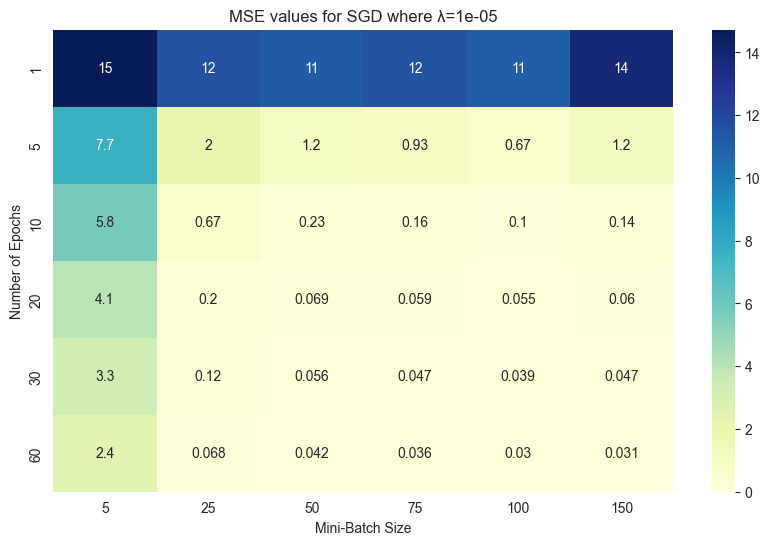

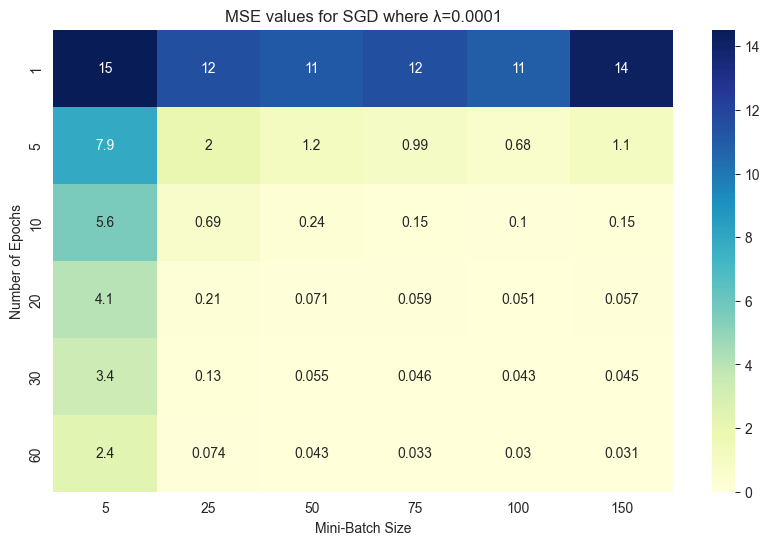

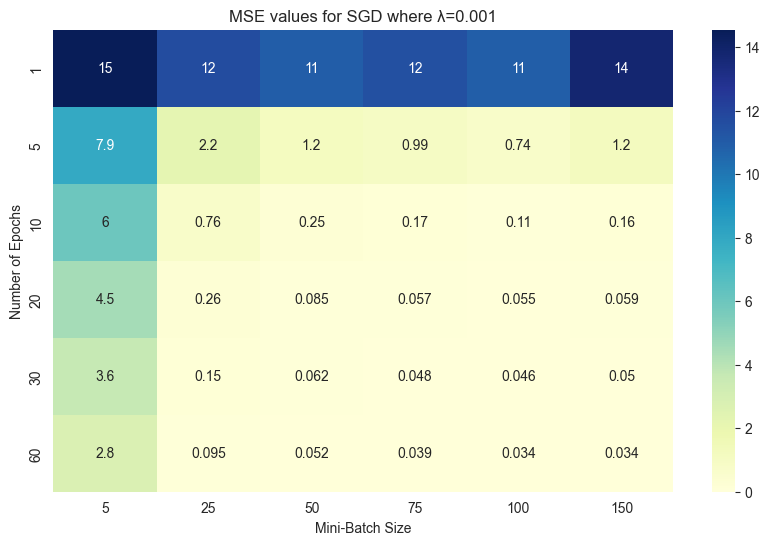

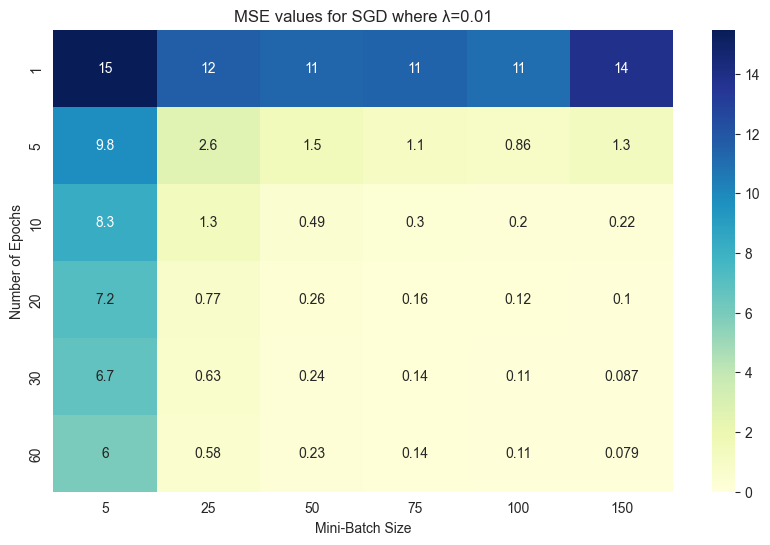

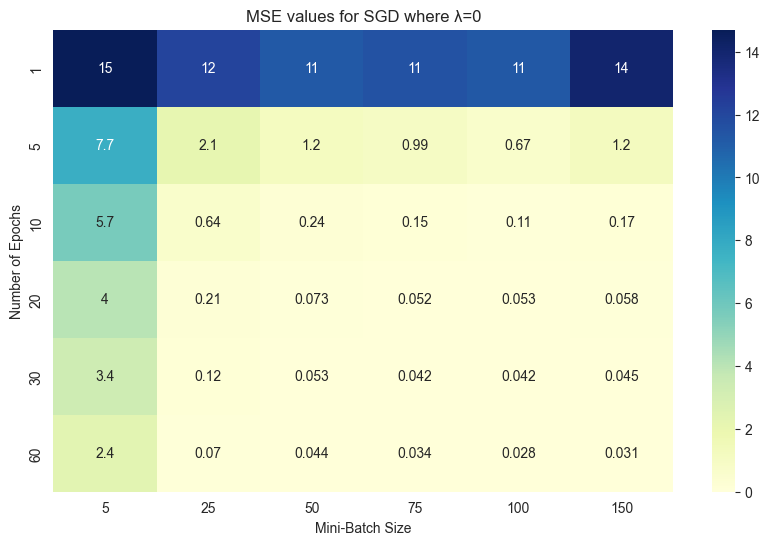

In [30]:

np.random.seed(2014)
n = 400
x = np.random.rand(n,1)  
y = 2 + 3*x + 4*x**2 + 0.1*np.random.randn(n,1) 
p = 2  
X = Design(x, p)
beta = np.random.randn(p + 1, 1) 
batch_sizes = [5, 25, 50, 75, 100, 150] 
lambdas = [1e-5, 1e-4, 1e-3, 1e-2, 0]

plot_Ridge_OLS_MSE_changes_minibatch(X, y, beta, lambdas=lambdas, mini_batch_sizes=batch_sizes, epochs=[1, 5, 10, 20, 30, 60], t0=5, t1=50, momentum=0.3, change=0.0)

### Step 4: Adagrad
Implement the Adagrad method in order to tune the learning rate. Do this with and without momentum for plain gradient descent and SGD.

In [31]:
#Code taken from week 39 -Similar (second order function now) problem but now with AdaGrad
def AdagradGD(X, y, beta, n = 100, eta = 0.001, lmbda = 0, Niterations = 100, ridge = False, momentum = False,  delta_momentum = 0.3, delta=1e-8):
    change = 0.0
    Giter=0.0
    
    for iter in range(Niterations):
        if ridge == False:
            gradient = autograd_gradient(X, y, beta, lmbda)
        else:
            gradient = autograd_gradient(X, y, beta, lmbda)

        Giter += gradient**2
        update = eta * gradient / (delta + np.sqrt(Giter))

        if momentum:
            new_change = update + delta_momentum * change
            beta -= new_change
            change = new_change
        else:
            beta -= update

    return beta

#with mini batches
def Adagrad_SGD(X, y, beta, n = 100, n_epochs=50, batch_size=5, eta=0.01, ridge = False, lmbda = 0, momentum = False,  delta_momentum=0.3, delta=1e-8):
    M = batch_size
    m = int(n / M)
    change = 0.0
    Giter=0.0

    for epoch in range(n_epochs):
        for i in range(m):
            random_index = M * np.random.randint(m)
            xi = X[random_index:random_index + M]
            yi = y[random_index:random_index + M]

            if ridge == False:
                gradients = autograd_gradient(xi, yi, beta, lmbda)
            else:
                gradients = autograd_gradient(xi, yi, beta, lmbda)

            Giter += gradients**2
            update = eta * gradients / (delta + np.sqrt(Giter))

            if momentum:
                new_change = update + delta_momentum * change
                beta -= new_change
                change = new_change
            else:
                beta -= update

    return beta



### Step 5: RMSprop and Adam 
Add RMSprop and Adam to your library of methods for tuning the learning rate.

In [32]:
#Taken from week 39 - RMSprop for adaptive learning rate with Stochastic Gradient Descent
#RMSprop_SGD with mini batches and momentum
def RMSprop_SGD(X, y, beta, n = 100,  n_epochs=100, batch_size=5, eta=0.01, ridge = False,lmbda=0.01, rho=0.99, delta=1e-8):
    M = batch_size
    m = int(n / M)
    Giter=0.0

    for epoch in range(n_epochs):
        for i in range(m):
            random_index = M * np.random.randint(m)
            xi = X[random_index:random_index + M]
            yi = y[random_index:random_index + M]

            if ridge == False:
                gradients = autograd_gradient(xi, yi, beta, lmbda)
            else:
                gradients = autograd_gradient(xi, yi, beta, lmbda)

            Giter = rho * Giter + (1 - rho) * gradients**2
            update = eta * gradients / (delta + np.sqrt(Giter))
            beta -= update

    return beta


In [33]:
#Taken from week 39 -> And finally ADAM
def Adam_SGD(X, y, beta, n= 100,  n_epochs=100, batch_size=5, eta=0.01, ridge = False, lmbda = 0.01,  beta1=0.9, beta2=0.999, delta=1e-8):
    M = batch_size
    m = int(n / M)
    first_moment = 0.0
    second_moment = 0.0
    iter=0
    for epoch in range(n_epochs):
        iter += 1
        for i in range(m):
            random_index = M * np.random.randint(m)
            xi = X[random_index:random_index + M]
            yi = y[random_index:random_index + M]

            if ridge == False:
                gradients = autograd_gradient(xi, yi, beta, lmbda)
            else:
                gradients = autograd_gradient(xi, yi, beta, lmbda)

            first_moment = beta1 * first_moment + (1 - beta1) * gradients
            second_moment = beta2 * second_moment + (1 - beta2) * gradients**2
            first_unbias = first_moment / (1 - beta1**iter)
            second_unbias = second_moment / (1 - beta2**iter)
            update = eta * first_unbias / (np.sqrt(second_unbias) + delta)
            beta -= update

    return beta


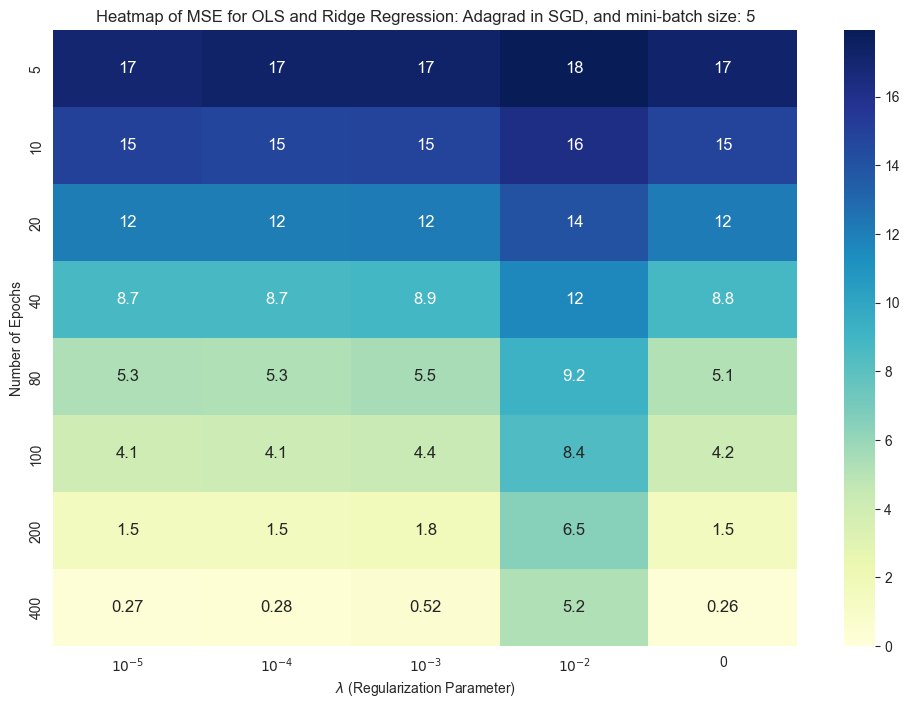

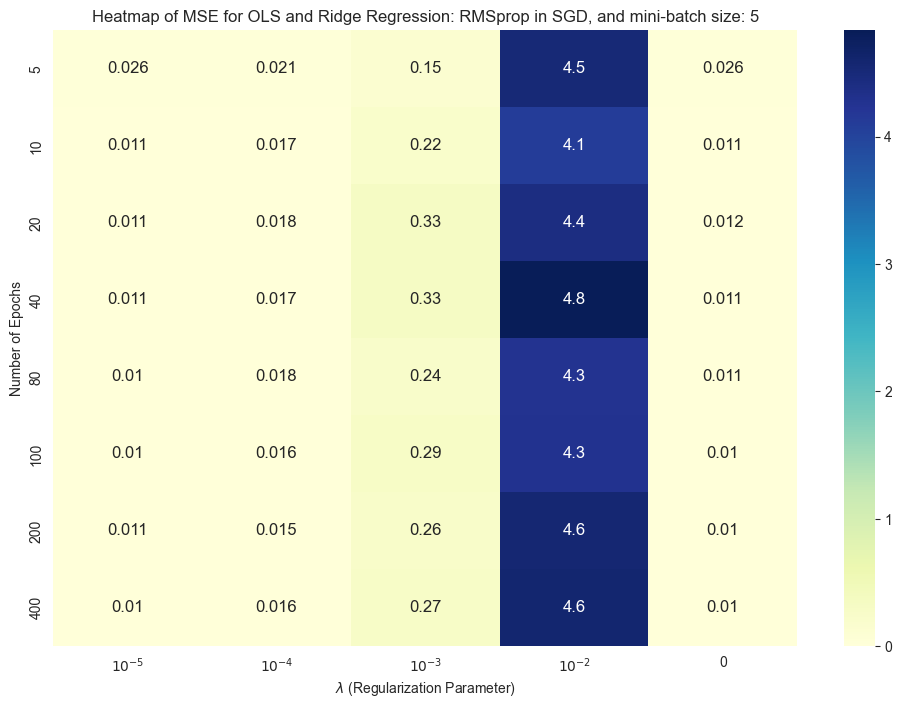

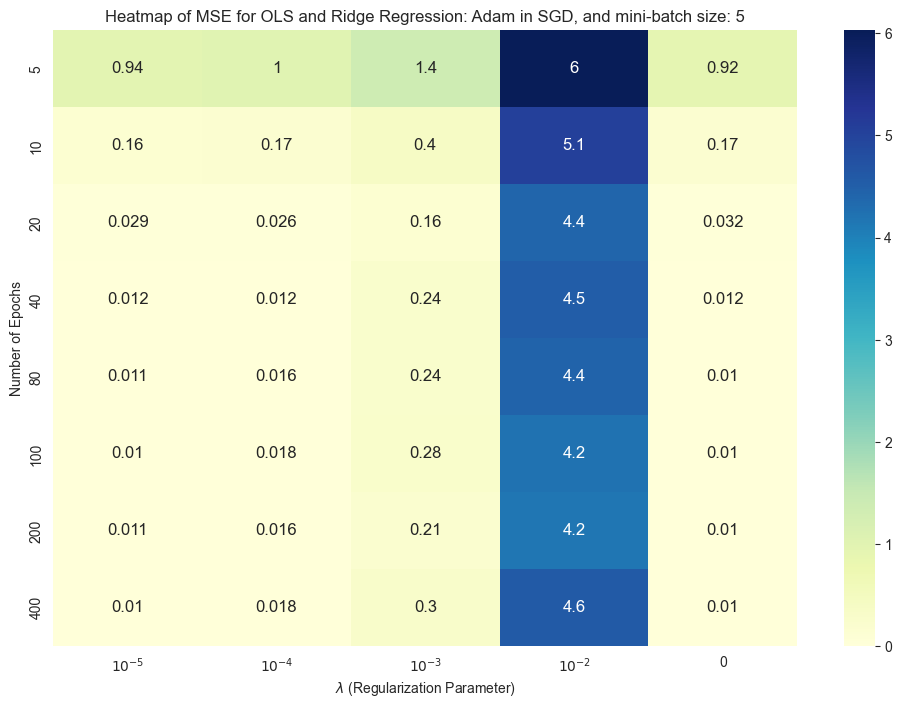

In [34]:
#Plotting the heatmap for the three methods showing the effect of Adagrad, RMSprop and Adam
def plot_OLS_Ridge_heatmap_adaptive_methods(X, y, beta, lambdas, epoch_counts=[5, 10, 20, 40, 80, 100], batch_size=5):
    methods = {
        "Adagrad": Adagrad_SGD,
        "RMSprop": RMSprop_SGD,
        "Adam": Adam_SGD
    }

    for method_name, method_func in methods.items():
        mse_values = np.zeros((len(epoch_counts), len(lambdas)))

        for i, n_epochs in enumerate(epoch_counts):
            for j, lmbda in enumerate(lambdas):
                # Run the adaptive method with the specified number of epochs and lambda
                beta_result = method_func(X, y, beta.copy(), n=len(y), n_epochs=n_epochs, batch_size=batch_size, eta=eta, ridge=True, lmbda=lmbda)
                mse_values[i, j] = MSE(y, X @ beta_result)

        # Set up tick labels for heatmap
        xticks = [f"$10^{{{int(np.log10(val))}}}$" if val > 0 else "0" for val in lambdas]

        # Plotting the heatmap
        plt.figure(figsize=(12, 8))
        sns.heatmap(mse_values, annot=True, cmap="YlGnBu", yticklabels=epoch_counts, xticklabels=xticks, vmin=0, annot_kws={"fontsize": 12})
        plt.xlabel("$\lambda$ (Regularization Parameter)")
        plt.ylabel("Number of Epochs")
        plt.title(f"Heatmap of MSE for OLS and Ridge Regression: {method_name} in SGD, and mini-batch size: {batch_size}")
        plt.show()



np.random.seed(2014)
n = 400
x = np.random.rand(n, 1) 
y = 2 + 3*x + 4*x**2 + 0.1*np.random.randn(n, 1)  
p = 2  
X = Design(x, p)  
beta = np.random.randn(p + 1, 1)  

n_epochs = 300
batch_size = 5
lambdas = [1e-5, 1e-4, 1e-3, 1e-2, 0]

plot_OLS_Ridge_heatmap_adaptive_methods(X, y, beta, lambdas, batch_size=batch_size, epoch_counts = [5, 10, 20, 40, 80, 100, 200, 400])

In [35]:
import pandas as pd
#Comparing all the gradient descent methods after Niterations
def compare_gradient_descent_methods(X, y, beta_initial, eta=0.01, batch_size=5, Niterations=100, lmbda=0.01, delta_momentum=0.3, rho=0.99, beta1=0.9, beta2=0.999):
    results = {
        "Method": [],
        "MSE": []
    }

    # Plain GD
    final_beta = GD(X, y, np.copy(beta_initial), eta, momentum=False)
    y_pred = X @ final_beta
    results["Method"].append("Plain GD")
    results["MSE"].append(MSE(y, y_pred))

    # GD with Momentum
    final_beta = GD(X, y, np.copy(beta_initial), eta, momentum=True, delta_momentum=delta_momentum)
    y_pred = X @ final_beta
    results["Method"].append("GD with Momentum")
    results["MSE"].append(MSE(y, y_pred))

    # Plain Adagrad GD
    final_beta = AdagradGD(X, y, np.copy(beta_initial), n=X.shape[0], eta=eta, lmbda=lmbda, Niterations=Niterations, ridge=False, momentum=False)
    y_pred = X @ final_beta
    results["Method"].append("Adagrad GD")
    results["MSE"].append(MSE(y, y_pred))

    # Adagrad GD with Momentum
    final_beta = AdagradGD(X, y, np.copy(beta_initial), n=X.shape[0], eta=eta, lmbda=lmbda, Niterations=Niterations, ridge=False, momentum=True, delta_momentum=delta_momentum)
    y_pred = X @ final_beta
    results["Method"].append("Adagrad GD with Momentum")
    results["MSE"].append(MSE(y, y_pred))

    # Plain SGD
    final_beta = SGD(X, y, np.copy(beta_initial), n=X.shape[0], n_epochs=Niterations, batch_size=batch_size, ridge=False, momentum=0)
    y_pred = X @ final_beta
    results["Method"].append("Plain SGD")
    results["MSE"].append(MSE(y, y_pred))

    # SGD with Momentum
    final_beta = SGD(X, y, np.copy(beta_initial), n=X.shape[0], n_epochs=Niterations, batch_size=batch_size, ridge=False, momentum=delta_momentum)
    y_pred = X @ final_beta
    results["Method"].append("SGD with Momentum")
    results["MSE"].append(MSE(y, y_pred))

    # Plain Adagrad SGD
    final_beta = Adagrad_SGD(X, y, np.copy(beta_initial), n=X.shape[0], n_epochs=Niterations, batch_size=batch_size, eta=eta, ridge=False, momentum=False)
    y_pred = X @ final_beta
    results["Method"].append("Adagrad SGD")
    results["MSE"].append(MSE(y, y_pred))

    # Adagrad SGD with Momentum
    final_beta = Adagrad_SGD(X, y, np.copy(beta_initial), n=X.shape[0], n_epochs=Niterations, batch_size=batch_size, eta=eta, ridge=False, momentum=True, delta_momentum=delta_momentum)
    y_pred = X @ final_beta
    results["Method"].append("Adagrad SGD with Momentum")
    results["MSE"].append(MSE(y, y_pred))

    # RMSprop SGD
    final_beta = RMSprop_SGD(X, y, np.copy(beta_initial), n=X.shape[0], n_epochs=n_epochs, batch_size=batch_size, eta=eta, ridge=False, lmbda=lmbda, rho=rho, delta=1e-8)
    y_pred = X @ final_beta
    results["Method"].append("RMSprop SGD")
    results["MSE"].append(MSE(y, y_pred))

    # Adam SGD
    final_beta = Adam_SGD(X, y, np.copy(beta_initial), n=X.shape[0], n_epochs=n_epochs, batch_size=batch_size, eta=eta, ridge=False, lmbda=lmbda, beta1=beta1, beta2=beta2, delta=1e-8)
    y_pred = X @ final_beta
    results["Method"].append("Adam SGD")
    results["MSE"].append(MSE(y, y_pred))

    # Create DataFrame
    results_df = pd.DataFrame(results)
    return results_df


np.random.seed(2014)
n = 400
x = np.random.rand(n,1)
y = 2 + 3*x + 4*x**2 + 0.1*np.random.randn(n,1)
p = 2
X = Design(x, p)
beta = np.random.randn(p+1, 1)

results_df = compare_gradient_descent_methods(X, y, beta, Niterations = 400)
results_df


,Method,MSE
0,Plain GD,0.142464
1,GD with Momentum,0.061130
2,Adagrad GD,16.972084
3,Adagrad GD with Momentum,14.638635
4,Plain SGD,2.488116
5,SGD with Momentum,0.991222
6,Adagrad SGD,0.259945
7,Adagrad SGD with Momentum,0.037146
8,RMSprop SGD,4.294787
9,Adam SGD,4.457402
